# <p style='color:#f70'> **Spaceship Titanic - Kaggle**

Predict which passengers are transported to an alternate dimension
- https://www.kaggle.com/competitions/spaceship-titanic/

#### <p style='color:#f70'> Data Description
- **PassengerId**
  - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates A group the passenger is travelling with and pp is their Cabin_number within the group. People in a group are often family members, but not always.
- **HomePlanet**
  - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep**
  - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin**
  - The cabin cabin_number where the passenger is staying. Takes the form deck/num/side, where cabin_side can be either P for Port or S for Starboard.
- **Destination**
  - The planet the passenger will be debarking to.
- **Age**
  - The age of the passenger.
- **VIP**
  - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**
  - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name**
  - The first and last names of the passenger.
- **Transported**
  - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

#### <p style='color:#f70'> EDA/Research Questions:

Collated notes here as EDA was carried out below.
- **Did ____ affect whether passenger is Transported?**
  - **groupsize** (derived from PassengerId)
    - mean probability of being Transported >50% for groupsize 2-8, <50% for groups of 1 or 8
      - nonlinearity here. basic linear model won't work well (unless we used category bins)
  - **HomePlanet**
    - more than half the Europers transported
    - less than half the Earthers transported
    - Martians were about 50-50 split
  - **Cryosleep**
    - most of those in Cryosleep transported. (significant)
  - **Cabin**
    - cabin numbers 0-250, 750-1250, more than 50% Transported, all other numbers lower than 50%
    - cabin decks B,C, >50% of Transported.
    - cabin decks D E T, <50% of Transported
    - cabin side Starboard slightly >50% prob
    - cabin side Port slightly <50% prob
  - **Destination**
    - going to Trappist-1e, slightly more than half did not transport
    - going to 55 Cancri e, more than half transported.
    - going to PSO J318.5-22, 50-50% split.
  - **Age**
    - under age 15, higher than 50% likelihood of being Transported.
    - otherwise, no pronounced effect, age distribution between Transported and not Transported similar.
    - Also, under aged 12 practically spent $0 in RoomService/ShoppingMall/Spa/FoodCourt/VRDeck.
  - **VIP**
    - No significant difference
  - **RoomService**
    - Transported tended to spend less (close to 0)(likely correlated to being in CryoSleep)
  - **FoodCourt**
    - No significant difference
  - **ShoppingMall**
    - No significant difference
  - **Spa**
    - Transported tended to spend less (close to 0)(likely correlated to being in CryoSleep)
  - **VRDeck**
    - Transported tended to spend less (close to 0)(likely correlated to being in CryoSleep)

Overall, doesn't look like linear models might work well.


# <p style='color:#f70'> **1. EDA**

## <p style='color:#f70'> Define plot functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# DEFINE PLOTTING FUNCTIONS
import warnings
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def histplot_train_test(train, test, features, target, bins=20, figsize=(15,7), \
    title="Distributions for Continuous Features in Train and Test Sets, \
    and Mean Target Probability", colors=['#abcd00', '#00cdab'], log=False):
    """
    Plots overlaid histograms of train and test features to review distributions.
    Also plots mean target probability between 0 and 1, for a binary target, for the train set.

        Bins - specify number of bins for histograms
    """

    if len(features)==1:
        fig, ax = plt.subplots(1, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = [ax]
    elif len(features)==2:
        fig, ax = plt.subplots(1, 2, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    else:
        fig, ax = plt.subplots(2, int(np.ceil(len(features)/2)), figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    fig.suptitle(title)

    for col, ax in zip(features, axs):
        if (train[col].dtype != 'float64') and (train[col].dtype != 'int64'):
            print('Warning, {} is not a numeric dtype.')
        else:
            if log is True:
                ax.semilogx()
                ax.set_xlim(0.1,train[col].max())
            ax.hist(train[col].dropna(), alpha=0.5, color=colors[0], bins=bins, label='train')
            ax.hist( test[col].dropna(), alpha=0.5, color=colors[1], bins=bins, label='test')

            ax2 = ax.twinx()

            # drop missing values otherwise np.histogram spits errors.
            total, _      = np.histogram(train[col].dropna(), bins=bins)
            targetprob, _ = np.histogram(train[col][train[target] == 1].dropna(), bins=bins) 
            xvals = np.histogram(train[col].dropna(), bins=bins)[1][:-1]

            with warnings.catch_warnings(): # ignore divide by zero for empty bins
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                ax2.scatter(xvals, (targetprob / total), color='m', s=10, alpha=0.7, label='target probability')
                ax2.plot(xvals, (targetprob / total), color='m', alpha=0.2)
                ax2.set_ylim(0,1)
                ax2.set_ylabel('mean target', color='m')
                ax2.tick_params(axis='y', colors='m')
                ax2.axhline(0.5, color='m', alpha=0.1)

            ax.set_title(col)
            ax.legend()
    return None


def histplot_target(df, features, target, bins=20, figsize=(15,7), \
    title="Distributions for Continuous Features in Train Set, grouped by target label", \
    colors=['#abcd00', '#00cdab'], log=False):

    if len(features)==1:
        fig, ax = plt.subplots(1, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = [ax]
    elif len(features)==2:
        fig, ax = plt.subplots(1, 2, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    else:
        fig, ax = plt.subplots(2, int(np.ceil(len(features)/2)), figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    fig.suptitle(title)

    for col, ax in zip(features, axs):
        if (df[col].dtype != 'float64') and (df[col].dtype != 'int64'):
            print('Warning, {} is not a numeric dtype.')
        else:
            if log is True:
                ax.semilogx()
                ax.set_xlim(0.1,df[col].max())
            sns.histplot(data=df, x=col, hue=target, palette='bright', bins=bins, kde=True, ax=ax, alpha=0.3, color=colors)    
    return None


def boxplot_target(df, features, target, figsize=(15,6), colors=['#abcd00', '#00cdab'], title='Boxplots for Continuous Features in Train Set, grouped by target label'):

    if len(features)==1:
        fig, ax = plt.subplots(1, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = [ax]
    elif len(features)==2:
        fig, ax = plt.subplots(1, 2, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    else:
        fig, ax = plt.subplots(2, int(np.ceil(len(features)/2)), figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    fig.suptitle(title)

    for col, ax in zip(features, axs):
        sns.boxplot(data=df, x=target, y=col, ax=ax, palette='bright')
   
    # plt.figure(figsize=figsize)
    # plt.boxplot([df[f] for f in features], whis=1.5, labels=[f for f in features]) # default is 1.5 (* IQR)
    return None




def barplot_train_test(train, test, features, target, figsize=(15,7), \
    title="Distributions for Categorical Features in Train and Test Sets, and Mean Target Probability", \
    colors=['#abcd00', '#00cdab']):

    if len(features)==1:
        fig, ax = plt.subplots(1, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = [ax]
    elif len(features)==2:
        fig, ax = plt.subplots(1, 2, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    else:
        fig, ax = plt.subplots(2, int(np.ceil(len(features)/2)), figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    fig.suptitle(title)

    for col, ax in zip(features, axs):        
        train_counts = train[col].value_counts(dropna=False, normalize=True,)
        test_counts = test[col].value_counts(dropna=False, normalize=True,)
        targetprob = train[target].groupby(train[col], dropna=False).agg(['mean'])

        plot_table = pd.DataFrame()
        plot_table['train_counts'] = train_counts
        plot_table['test_counts'] = test_counts
        plot_table['target_mean'] = targetprob['mean']
        plot_table.sort_index(inplace=True)
        
        ax.bar( np.array(range(len(plot_table.index)))-.1, plot_table['train_counts'], alpha=0.5, width=0.2, color=colors[0], label='train')
        ax.bar( np.array(range(len(plot_table.index)))+.1, plot_table['test_counts'] , alpha=0.5, width=0.2, color=colors[1], label='test')

        for i, item in enumerate(np.array(range(len(plot_table.index)))):
            ax.text(item-0.2, plot_table['train_counts'].values[i], plot_table['train_counts'].values[i].round(2))
            ax.text(item+0.0,     plot_table['test_counts'].values[i] , plot_table['test_counts'].values[i].round(2) )

        ax.set_xlabel(col)
        ax.set_ylabel('frequency')
        ax.set_xticks(np.array(range(len(plot_table.index))), plot_table.index)
        ax.legend()

        ax2 = ax.twinx()

        ax2.scatter(range(len(plot_table.index)), plot_table['target_mean'], color='m', s=10, alpha=0.7, label='transport probability')
        ax2.plot(   range(len(plot_table.index)), plot_table['target_mean'], color='m', alpha=0.2)
        ax2.set_ylabel('mean Transported', color='m')
        ax2.tick_params(axis='y', colors='m')
        ax2.axhline(0.5, color='m', alpha=0.1)
        ax2.set_ylim(0,1)
        # display(plot_table)

    return


def barplot_target(df, features, target, title="Distributions for Categorical Features in Train Set, grouped by target label", colors=['#abcd00', '#00cdab'], figsize=(15,8)):

    if len(features)==1:
        fig, ax = plt.subplots(1, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = [ax]
    elif len(features)==2:
        fig, ax = plt.subplots(1, 2, figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    else:
        fig, ax = plt.subplots(2, int(np.ceil(len(features)/2)), figsize=figsize, \
            constrained_layout=True, num=title)
        axs = ax.ravel()
    fig.suptitle(title)

    for col, ax in zip(features, axs):
        # sns.displot(data=train, x=col, hue=target, palette='bright', normalize=True, bins=bins, kde=True, ax=ax)
        sns.countplot(data=df, x=col, hue=target, palette='bright', ax=ax)
    
    return

## <p style='color:#f70'> Load and Check Data

In [4]:
# define plot colors for train and test sets
colors = ['#abcd00', '#00cdab']

# load data
train = pd.read_csv('./data/train.csv').drop('Name', axis=1)
test  = pd.read_csv('./data/test.csv' ).drop('Name', axis=1)

# labelling columns for easy access
target    = 'Transported'
allcols   = [col for col in test.columns ]
floatcols = [col for col in test.columns if test[col].dtype == 'float64']
strcols   = [col for col in test.columns if test[col].dtype == 'object']

# convert target column 'True'/'False' into 1 and 0
train[target] = train[target].replace({'False':0, 'True':1, }).astype('float64')

# combine train and test dfs for easy transformations where needed
both  = pd.concat([train,test])

# keep a log of work done for report at the end
log = []

Train Shape: (8693, 13) , Test Shape: (4277, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Transported   8693 non-null   float64
dtypes: float64(7), object(6)
memory usage: 1.4+ MB


None

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000,8693.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482,0.503624
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


Duplicates in train set: 0, (0.0%)
Duplicates in test set: 0, (0.0%)
Missing Values


PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Transported     4277
dtype: int64

missing at least 1 value, train: 22%
missing at least 1 value, test : 22%


<AxesSubplot:>

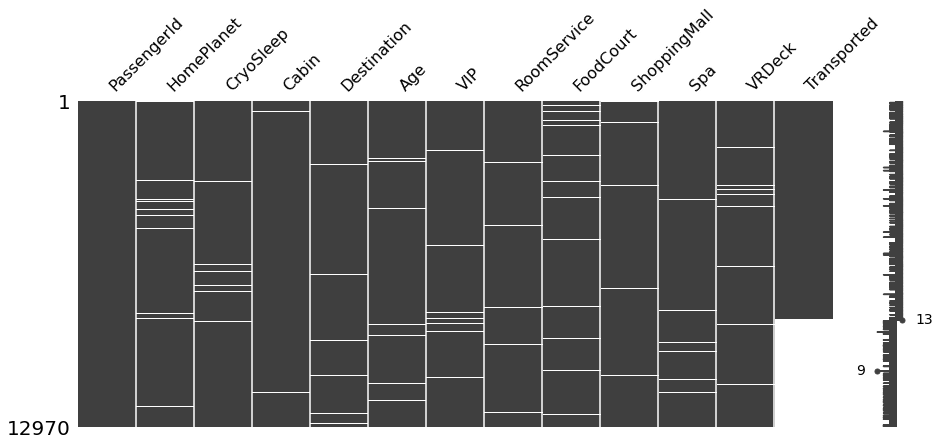

In [5]:
### CHECK DATA SHAPE, MISSING DATA
print("Train Shape: {} , Test Shape: {}".format(train.shape, test.shape))

display(both.info())
display(both.describe())

print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

# percentage missing by column, per df
pd.DataFrame([[train[col].isna().sum()/len(train[col]) for col in test.columns],[ test[col].isna().sum()/len(test[col]) for col in test.columns]], columns=test.columns, index=['train-missing','test-missing']).T
print('Missing Values')
display(both.isna().sum())

# how many rows contain at least 1 missing value
print(f"missing at least 1 value, train: {train[allcols].isna().any(axis=1).sum() / len(train):.0%}")
print(f"missing at least 1 value, test : {test[allcols].isna().any(axis=1).sum() / len(test):.0%}")

msno.matrix(both, figsize=(15,6))

## <p style='color:#f70'> EDA : Target

Transported Mean: 0.5036 --> classes quite balanced


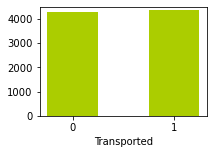

In [6]:
fig,ax = plt.subplots(figsize=(3,2))
plot_table = train[target].value_counts()

ax.bar(plot_table.index, plot_table, width=0.5, color=colors[0])
ax.set_xticks(plot_table.index)
ax.set_ylim(0,4500)
ax.set_xlabel(target)

print('Transported Mean: {} --> classes quite balanced'.format(round(train[target].mean(),4)))

## <p style='color:#f70'> EDA : Continuous Features

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


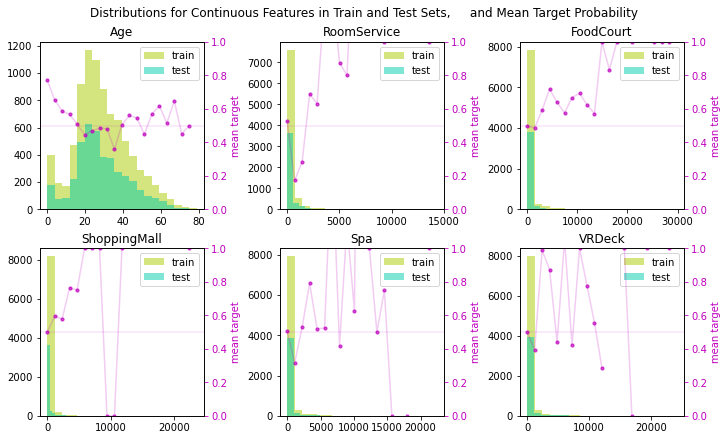

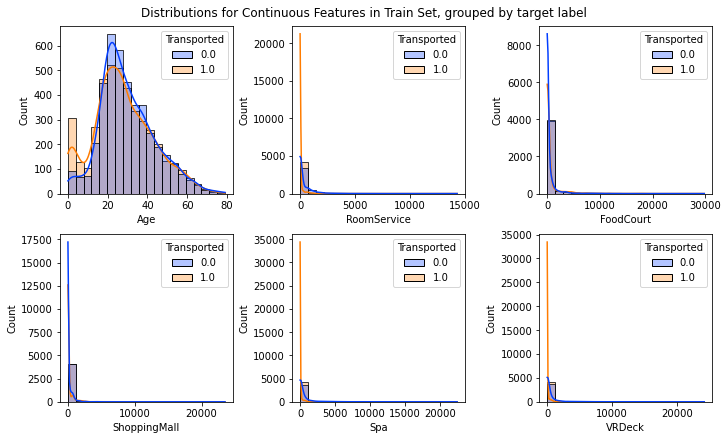

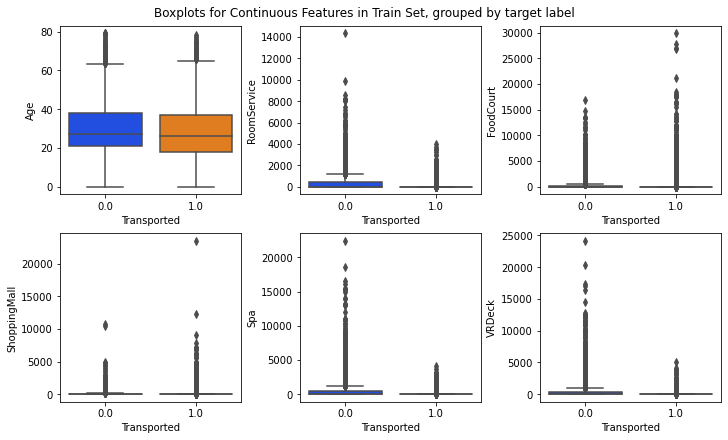

In [7]:
display(train.describe())
display( test.describe())
histplot_train_test(train,test,floatcols,target,bins=20, figsize=(10,6))
histplot_target(train,floatcols,target,bins=20, figsize=(10,6))
boxplot_target(train,floatcols,target, figsize=(10,6))

## <p style='color:#f70'> EDA : Categorical Features

In [8]:
# unique values for each column
for col in strcols:
    print(col, len(train[col].unique()))

PassengerId 8693
HomePlanet 4
CryoSleep 3
Cabin 6561
Destination 4
VIP 3


- Skip PassengerId and Cabin, we'll engineer features for those separately. As is, they have too many values to give any significance. We'll have to try and pool into more distinct groups.

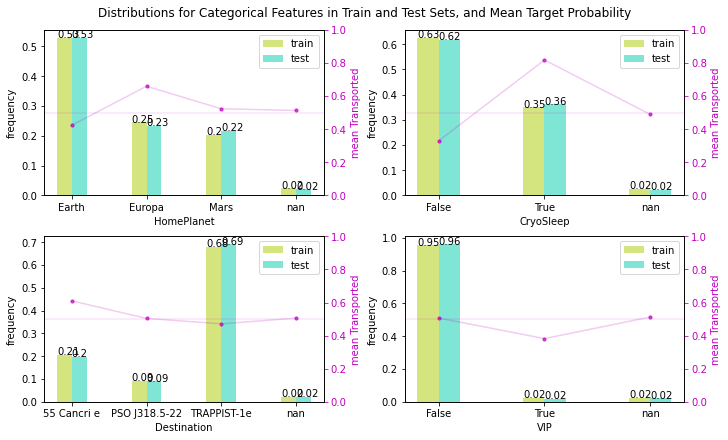

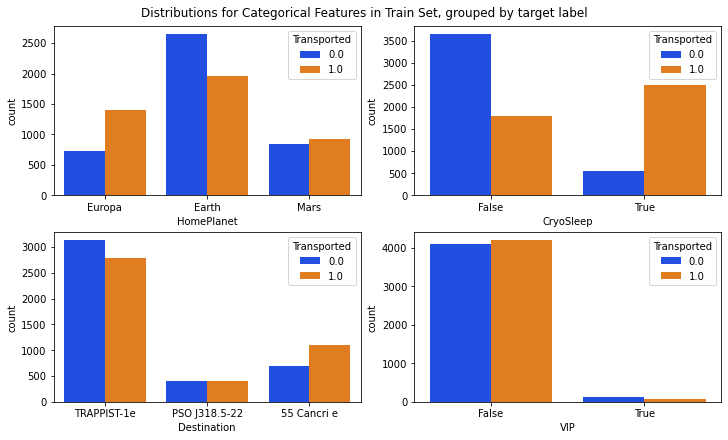

In [9]:
categcols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
barplot_train_test(train, test, categcols, target, figsize=(10,6))
barplot_target(train, categcols, target, figsize=(10,6))

Age            RoomService                 FoodCourt  \
                mean  amax amin        mean     amax amin        mean   
CryoSleep                                                               
False      29.651319  79.0  0.0  350.146772  14327.0  0.0  713.004316   
True       27.405415  78.0  0.0    0.000000      0.0  0.0    0.000000   

                        ShoppingMall                      Spa                \
              amax amin         mean     amax amin       mean     amax amin   
CryoSleep                                                                     
False      29813.0  0.0   270.586504  23492.0  0.0  486.09294  22408.0  0.0   
True           0.0  0.0     0.000000      0.0  0.0    0.00000      0.0  0.0   

               VRDeck                
                 mean     amax amin  
CryoSleep                            
False      475.716165  24133.0  0.0  
True         0.000000      0.0  0.0

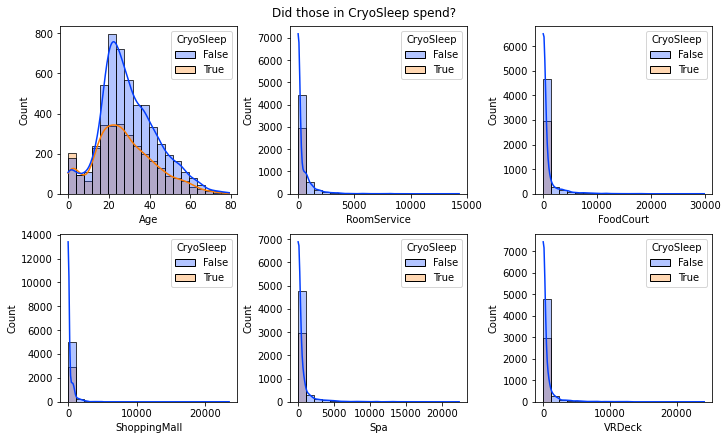

In [10]:
histplot_target(train,floatcols,'CryoSleep',title='Did those in CryoSleep spend?', figsize=(10,6))
train.groupby('CryoSleep')[floatcols].agg([np.mean, np.max, np.min])

- Those in CryoSleep did not spend.

- Children aged 12 and under seemed to not spend

In [11]:
agelimit=12
cols = floatcols + [target]
display(train.loc[train['Age']<=agelimit, cols].agg([np.mean]))
display(train.loc[train['Age']> agelimit, cols].agg([np.mean]))


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
mean,4.516129,0.0,0.0,0.0,0.0,0.0,0.699752


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
mean,31.370135,249.450715,507.269991,193.549575,342.86008,336.998013,0.483134


In [12]:
train.corr()['Age']

Age             1.000000
RoomService     0.068723
FoodCourt       0.130421
ShoppingMall    0.033133
Spa             0.123970
VRDeck          0.101007
Transported    -0.075026
Name: Age, dtype: float64

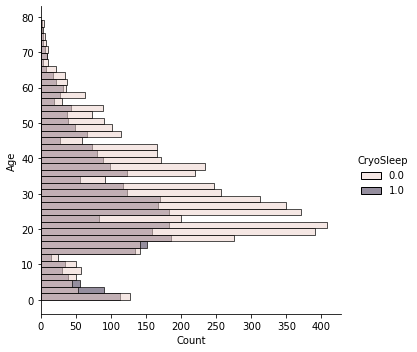

In [13]:
sns.displot(data=train, y='Age', hue='CryoSleep')

# <p style='color:#f70'> **2. BEGIN PREPROCESSING**

## <p style='color:#f70'> Impute missing continuous features

- With missing data, either drop rows, or impute.
- In our case, impute because too much is missing, plus the test set contains missing data too, so we'll have to deal with it anyway in order to make predictions.

In [14]:
### IMPUTE BY EDA
# we saw that those in CryoSleep and children 12 and under did not spend.
np.sum(train.isna().sum()) # 2124

for df in [train,test]:
    for cols in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df.loc[(df['CryoSleep']==True) & (df[col].isna()), col] = 0
        df.loc[(df['Age']<=12) & (df[col].isna()), col] = 0

np.sum(train.isna().sum()) # 2035, helped a little

log.append('impute: some 0s based on EDA (Cryosleep spent 0, children 12 and under spent 0.)')

In [15]:
### IMPUTE THE REST WITH KNNIMPUTER
from sklearn.impute import KNNImputer

# select numeric columns for imputation
numericcols = [c for c in train.columns if train[c].dtype=='int64'] + [c for c in train.columns if train[c].dtype=='float64']
numericcols = [c for c in numericcols if c!=target]
both = pd.concat([train,test])

# fit and transform
imputer = KNNImputer(n_neighbors=9, weights='distance').fit(train[numericcols])

train[numericcols] = imputer.transform(train[numericcols])
test[numericcols] =  imputer.transform(test[numericcols])
both  = pd.concat([train,test])

log.append('impute: other numeric cols using KNNImputer.fit(train)')

<AxesSubplot:>

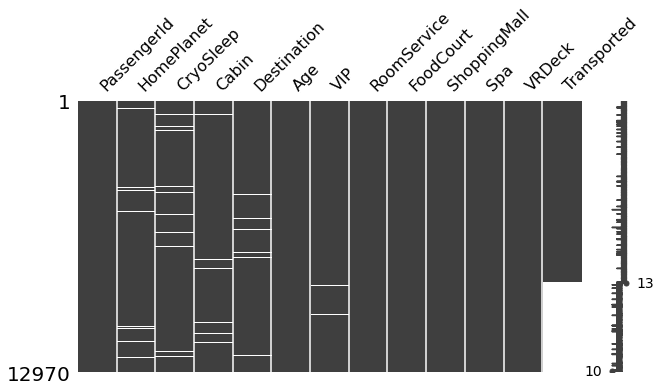

In [16]:
msno.matrix(both, figsize=(10,5))

## <p style='color:#f70'> Impute missing categoricals

Only categoricals have blanks left. There could be meaning in it, e.g. 
- stowaways don't have cabins? we don't know if this passenger manifest is from ticketing (so then they should all have tickets and assigned cabins)
- it could be that unlabelled CryoSleep means no CryoSleep? Seems like CryoSleep would be something you have to pre-register and arrange for.
- HomePlanet - we can check those whose passengerid prefix match and fill.


In [17]:
for df in [train,test]:
    for col in ['HomePlanet','Cabin','Destination','VIP']:
        print(col, len(df[df[col].isna()].index))

HomePlanet 201
Cabin 199
Destination 182
VIP 114
HomePlanet 87
Cabin 100
Destination 92
VIP 62


('HomePlanet', 90)
('Cabin', 100)
('Destination', 79)
('VIP', 43)
('HomePlanet', 0)
('Destination', 0)
('VIP', 0)
('HomePlanet', 41)
('Cabin', 37)
('Destination', 41)
('VIP', 21)
('HomePlanet', 0)
('Destination', 0)
('VIP', 0)


<AxesSubplot:>

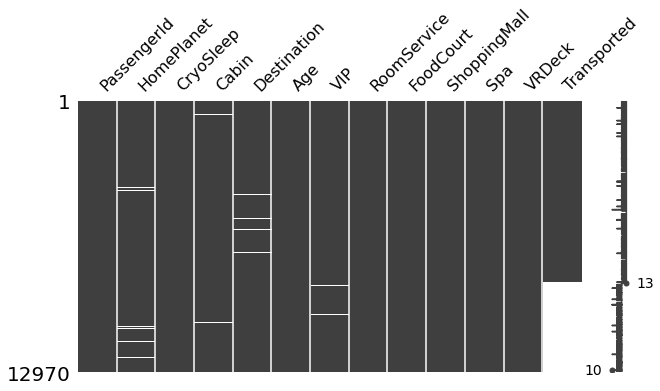

In [18]:
def fill_missing_cat(df, col, check):
    rowsfilled = 0
    missing_idx = list(df[df[col].isna()].index)
    for idx in missing_idx:
        # get passenger idprefix
        idprefix = (df.loc[idx, check])
        
        # pull out the col value for anyone else with the same idprefix
        missingvalue = df.loc[(df[check]==idprefix) & (df[col].notna()), col].tolist()

        # if we find any matching column value, fill the original missing item with the mode
        if len(missingvalue)>0:
            df.loc[idx, col] = max(set(missingvalue), key = missingvalue.count)
            rowsfilled += 1
    return (col,rowsfilled)

for df in [train,test]:
    df['CryoSleep'].fillna(train['CryoSleep'].mode()[0], inplace=True)

    # find indexes of where df['HomePlanet'] are blank.
    # process the prefix passengerid, backfill using values from matching passenger id prefix
    df[['idprefix','idsuffix']] = df['PassengerId'].str.extract(r"(\d{4})_(\d{2})")
    df.idprefix = df.idprefix.astype('int64')
    df.idsuffix = df.idsuffix.astype('int64')

    # fill missing categorical values of that column by checking corresponding
    # function returns col name and num of rows filled.
    print(fill_missing_cat(df, col='HomePlanet',  check='idprefix'))
    print(fill_missing_cat(df, col='Cabin',       check='idprefix'))
    print(fill_missing_cat(df, col='Destination', check='idprefix'))
    print(fill_missing_cat(df, col='VIP',         check='idprefix'))
    print(fill_missing_cat(df, col='HomePlanet',  check='Cabin'))
    print(fill_missing_cat(df, col='Destination', check='Cabin'))
    print(fill_missing_cat(df, col='VIP',         check='Cabin'))
    
    
    df.drop(['idprefix','idsuffix'], inplace=True, axis=1)

both = pd.concat([train,test])

msno.matrix(both, figsize=(10,5))

In [19]:
for df in [train,test]:
    for col in ['HomePlanet','Cabin','Destination','VIP']:
        print(col, len(df[df[col].isna()].index))

HomePlanet 111
Cabin 99
Destination 103
VIP 71
HomePlanet 46
Cabin 63
Destination 51
VIP 41


We have improved it a bit. The rest which are still missing, we will treat as separate nan category in the classifier.

## <p style='color:#f70'> Feature Engineering

- **PassengerId**
  - make a feature called groupsize by counting how many passengers have the same prefix (e.g. 1234_01, 1234_02, 1234_03)
- **Cabin** 
  - is coded as deck/number/side. 
  - Split this out into 3 separate fields, as the locations might be important to the target label
- **Age**
  - also bin Age into age_groups of 3 years per bin.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**
  - tried to bin these logarithmicly, but evaluation scores were lower than just leaving as is. So skipping.

In [20]:
for df in [train, test]:
    
    # parse PassengerId into groupsize
    df[['idprefix','idsuffix']] = df['PassengerId'].str.extract(r"(\d{4})_(\d{2})")
    df.idprefix = df.idprefix.astype('int64')
    df.idsuffix = df.idsuffix.astype('int64')
    df['groupsize'] = df['idprefix'].map(df['idprefix'].value_counts())
    df.drop(['idprefix','idsuffix'], inplace=True, axis=1)

    # parse Cabin cabin_number into cabin_deck, room, cabin_side(port/starboard)
    df[['cabin_deck','cabin_number','cabin_side']] = df['Cabin'].str.extract(r"(\w{1})\/(\d+)\/(\w{1})")
    df['cabin_deck'] = df['cabin_deck'].astype('object')
    df['cabin_number'] = df['cabin_number'].astype('float64')
    df['cabin_side'] = df['cabin_side'].astype('object')

    # bin Age, cabin cabin_number
    df['cabin_number_group'] = pd.cut(df['cabin_number'].fillna(np.nan), bins=np.arange(0,2000,100), include_lowest=True, right=False) 
    df['age_group'] = pd.cut(df['Age'].fillna(np.nan), bins=np.arange(0,90,3), right=False, include_lowest=True)

    # make expenditure bins in logspace. skipped as didn't help scores.
    # bins = np.logspace(start=-1,stop=16, num=18, base=2)
    # df['RoomService_group']  = pd.cut(df['RoomService'].fillna(np.nan), bins=bins)
    # df['FoodCourt_group']    = pd.cut(df['FoodCourt'].fillna(np.nan), bins=bins)
    # df['ShoppingMall_group'] = pd.cut(df['ShoppingMall'].fillna(np.nan), bins=bins)
    # df['Spa_group']          = pd.cut(df['Spa'].fillna(np.nan), bins=bins)
    # df['VRDeck_group']       = pd.cut(df['VRDeck'].fillna(np.nan), bins=bins)

    # make total expenditure across all ship amenities
    df['sumspend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

    # log transform expenditure features
    floatcols_totransform = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','sumspend']
    floatcols_log=[]
    for col in floatcols_totransform:
        newcol = col + '_log'
        floatcols_log.append(newcol)
        df[newcol] = df[col].map(lambda x: np.log(x) if x>0 else 0)
    
both = pd.concat([train,test])

log.append("new_features: int groupsize, str cabin_deck, int cabin_number, str cabin_side, float sumspend")
log.append("new_features: log_transform: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, sumspend")
log.append("new_features: age_group bins=arange(-1,90,3), cabin_number_group bins=np.arange(0,2000,100)")


## <p style='color:#f70'> EDA: Examine engineered features

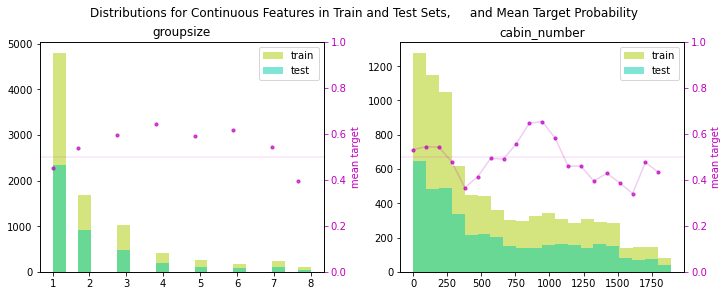

In [21]:
### NEW NUMERIC COLUMNS
newnumcols = ['groupsize','cabin_number']
histplot_train_test(train,test,newnumcols,target, figsize=(10,4))

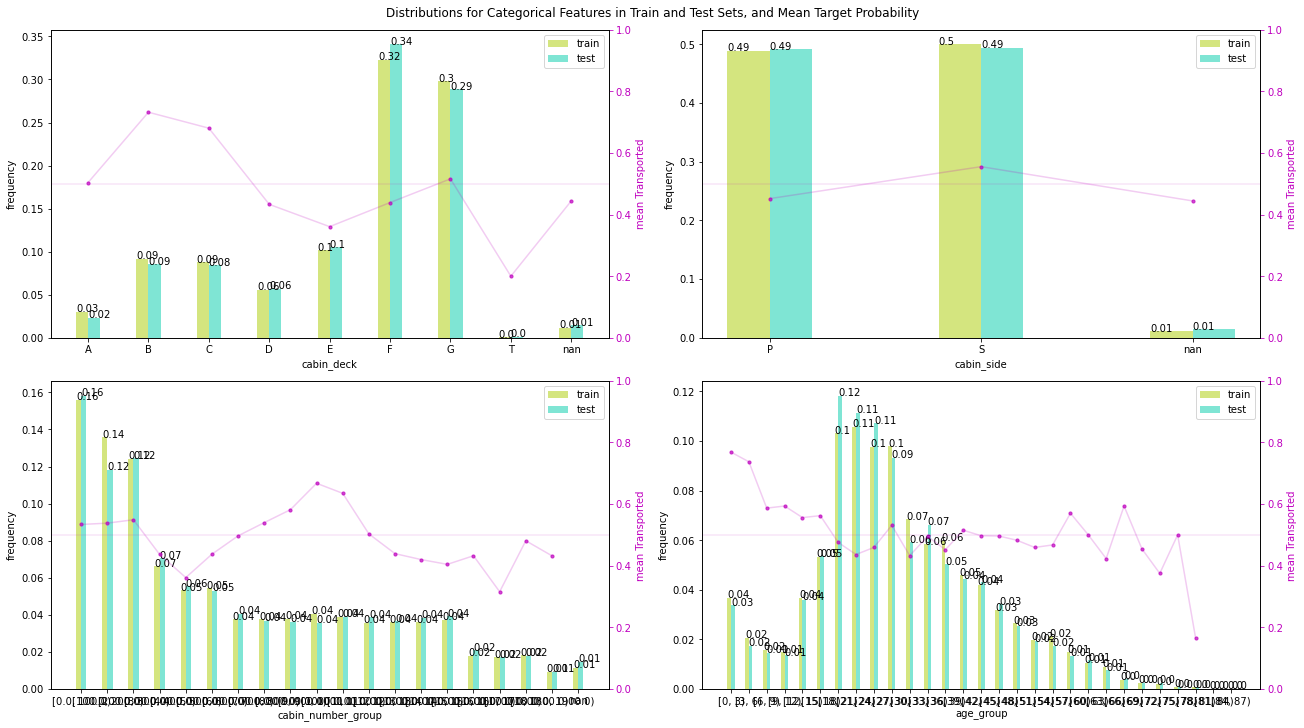

In [22]:
### NEW CAT COLUMNS
newcategcols = ['cabin_deck', 'cabin_side', 'cabin_number_group', 'age_group']
barplot_train_test(train,test,newcategcols,target, figsize=(18,10))

,mean,amax,amin
cabin_number_group,,,
"[0, 100)",2471.031037,31076.000000,0.0
"[100, 200)",2179.586060,35987.000000,0.0
"[200, 300)",2241.140010,30478.000000,0.0
"[300, 400)",1433.935088,23774.000000,0.0
"[400, 500)",901.561171,18166.000000,0.0
"[500, 600)",838.880617,25561.737830,0.0
"[600, 700)",614.906047,7177.000000,0.0
"[700, 800)",660.379978,3930.000000,0.0
"[800, 900)",711.985853,7347.000000,0.0


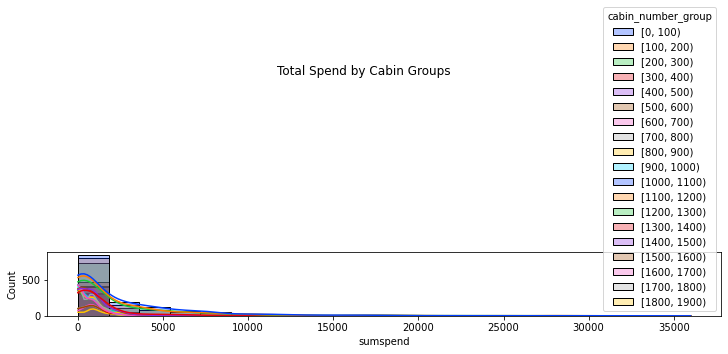

In [23]:
histplot_target(train,['sumspend'],'cabin_number_group',title='Total Spend by Cabin Groups', figsize=(10,4))
train.groupby('cabin_number_group')['sumspend'].agg([np.mean, np.max, np.min])

,mean,amax,amin
cabin_number_group,,,
"[0, 100)",0.533923,1.0,0.0
"[100, 200)",0.538136,1.0,0.0
"[200, 300)",0.549165,1.0,0.0
"[300, 400)",0.436522,1.0,0.0
"[400, 500)",0.361472,1.0,0.0
"[500, 600)",0.437367,1.0,0.0
"[600, 700)",0.496933,1.0,0.0
"[700, 800)",0.539877,1.0,0.0
"[800, 900)",0.581818,1.0,0.0


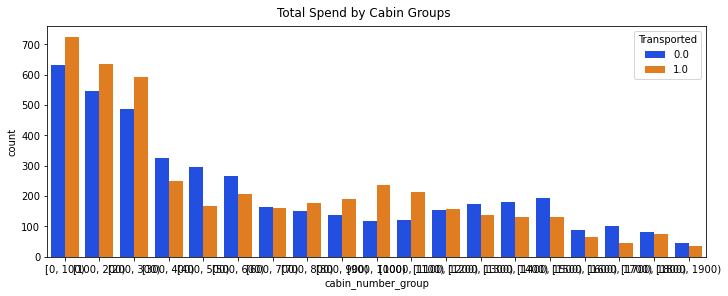

In [24]:
barplot_target(train,['cabin_number_group'],'Transported',title='Total Spend by Cabin Groups', figsize=(10,4))
train.groupby('cabin_number_group')['Transported'].agg([np.mean, np.max, np.min])

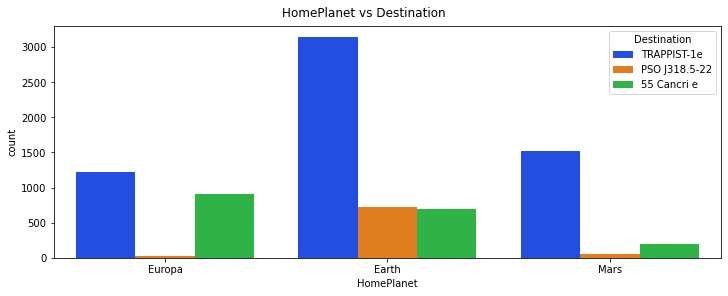

In [25]:
barplot_target(train,['HomePlanet'],'Destination',title='HomePlanet vs Destination', figsize=(10,4))

## <p style='color:#f70'> Outliers - Continuous Features

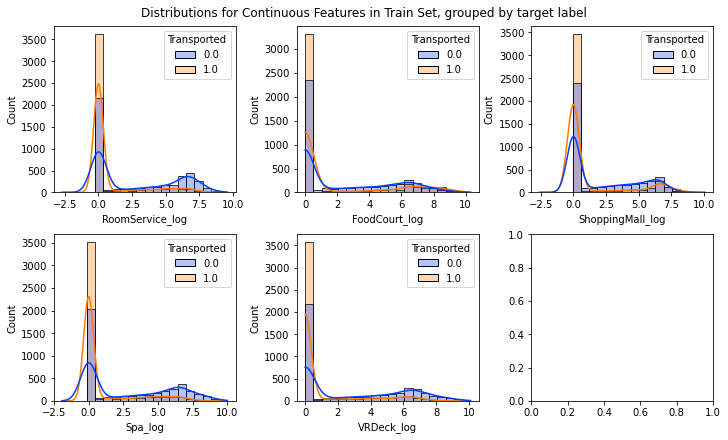

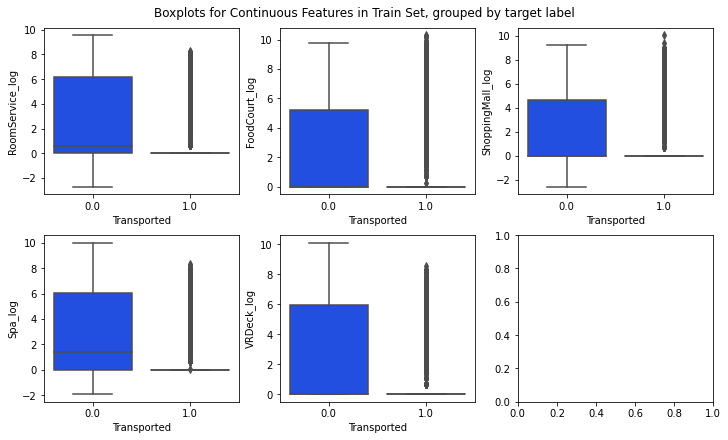

In [26]:
# compare before and after
spendcols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spendcols_log = ['RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log', 'VRDeck_log']

histplot_target(train, spendcols_log, target, bins=20, figsize=(10,6))
boxplot_target(train, spendcols_log, target, figsize=(10,6))

In [27]:
def detect_outliers(df, features, n=1, whis=1.5):
    """
    loop through a list of features and returns indexes with outliers.
    in each loop, a data point is deemed an outlier if it is 1.5 IQR less than Q1 or more than Q3.
    each loop has its own set of outlier indices.
    after looping through all features, it will check for outliers that have occurred over n or more features
    and return that set of indices
    """
    outlier_idx = []
    for col in features:
        Q1 = np.percentile(df[col].dropna(), q=25)
        Q3 = np.percentile(df[col].dropna(), q=75)
        outlier_low  = Q1 - (whis* (Q3-Q1))
        outlier_high = Q3 + (whis * (Q3-Q1))
        outlier_list_col = df[(df[col] < outlier_low) | (df[col] > outlier_high)].index
        outlier_idx.extend(outlier_list_col)

    outlier_idx = Counter(outlier_idx)
    multiple_outliers = list(key for key, value in outlier_idx.items() if value >= n)
    return multiple_outliers

def clip_outliers(df, features, whis=1.5):
    """
    loop through a list of features and returns indexes with outliers.
    in each loop, a data point is deemed an outlier if it is 1.5 IQR less than Q1 or more than Q3.
    each loop has its own set of outlier indices.
    after looping through all features, it will check for outliers that have occurred over n or more features
    and return that set of indices
    """
    outlier_idx = []
    for col in features:
        Q1 = np.percentile(df[col].dropna(), q=25)
        Q3 = np.percentile(df[col].dropna(), q=75)
        outlier_low  = Q1 - (whis * (Q3-Q1))
        outlier_high = Q3 + (whis * (Q3-Q1))
        df.loc[(df[col] < outlier_low),  col] = outlier_low
        df.loc[(df[col] > outlier_high), col] = outlier_high

    outlier_idx = Counter(outlier_idx)
    return outlier_idx

In [28]:

##! This outlier method has a problem. Technically the whiskers detected on train and test sets differ. Skipping for now as doesn't really affect HGBM results.
# to look into sklearn preprocessors if there's any tool.


###? DROP OUTLIERS
# print(len(train),len(test),len(both))
# train.drop(outliers, inplace=True, axis=0)
# print(len(train),len(test),len(both),len(outliers))

clipoutliers = False

###? CLIP OUTLIERS
if clipoutliers==True:
    outliers_idx = detect_outliers(train, spendcols_log, 1, whis=1.5)
    print(outliers_idx)
    clip_outliers(train, spendcols_log, whis=1.5)

    outliers_idx = detect_outliers(test, spendcols_log, 1, whis=1.5)
    print(outliers_idx)
    clip_outliers(test, spendcols_log, whis=1.5)

    # review plots
    histplot_target(train, spendcols_log, target, bins=20, figsize=(10,6))
    boxplot_target(train, spendcols_log, target, figsize=(10,6))

    log.append('outliers: log features clipped at 1.5 IQR, original features left alone.')
else:
    log.append('outliers: not handled')

# <p style='color:#f70'> **3. FEATURE SELECTION AND MODELLING**

## <p style='color:#f70'> Feature Selection

In [29]:
train.corr()['Transported'].sort_values(ascending=False)

Transported         1.000000
CryoSleep           0.460132
groupsize           0.082644
FoodCourt           0.044112
ShoppingMall        0.007328
cabin_number       -0.046917
Age                -0.073218
FoodCourt_log      -0.137248
ShoppingMall_log   -0.181304
sumspend           -0.201577
VRDeck             -0.205691
Spa                -0.219703
RoomService        -0.243308
VRDeck_log         -0.339956
RoomService_log    -0.358305
Spa_log            -0.362783
sumspend_log       -0.467785
Name: Transported, dtype: float64

In [30]:
cat_features = [
    'HomePlanet',
    'CryoSleep',
    'Destination',
    'VIP',
    'cabin_deck',
    'cabin_side',
    'cabin_number_group',
    'age_group']

num_features = [
    'Age',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'sumspend',
    'RoomService_log',
    'FoodCourt_log',
    'ShoppingMall_log',
    'Spa_log',
    'VRDeck_log',
    'sumspend_log',
    'groupsize']

#? ALTERNATIVE COLUMN SELECTOR:
# num_features = data.select_dtypes(include=['int64', 'float64']).columns
# cat_features = data.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns

X = train.copy(deep=True)
y = X.pop(target)
X_exttest = test.copy(deep=True)

for df in [X, X_exttest]:
    df.set_index('PassengerId', inplace=True)    
    df = df[cat_features + num_features] # rearranging cats in front.

X[cat_features] = X[cat_features].astype("category")
X_exttest[cat_features] = X_exttest[cat_features].astype("category")

log.append('cat_features: ' + ', '.join(cat_features))
log.append('num_features: ' + ', '.join(num_features))

## <p style='color:#f70'> Model Selection using GridSearchCV & Pipeline

In [31]:
### SET UP PIPELINES
###? preprocessors
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

###? pipelines
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline

###? model selection & metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

###? models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


num_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer_ohe = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder(sparse=False)) 
])

cat_transformer_oe = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant')),
    #? typically OHE is used, but HistGradientBoostingRegressor/Classifier accepts native 
    #? categorical features (and has better train time and performance scores), so we can 
    #? pass in ordinally encoded features that will be treated as categoricals.
    ('encoder', OrdinalEncoder())
])

preprocessor_oe = ColumnTransformer(
    transformers=[
        ('categorical', cat_transformer_oe, cat_features),
        ('numeric',     num_transformer, num_features)
]) 

preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('categorical', cat_transformer_ohe, cat_features),
        ('numeric',     num_transformer, num_features)
]) 

cat_feature_mask = [True]*len(cat_features) + [False]*len(num_features) # for passing into HistGradientBoostingClassifier

log.append('onehot and ordinal encoders for cats, robustscaler for nums')

In [32]:
def modelevaluation(clfs):
    name, train_acc, test_acc, train_auc, test_auc, params = [], [], [], [], [], []
    for clf in clfs:
        name.append(clf)
        clf = eval(clf)
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred  = clf.predict(X_test)
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))
        train_auc.append(roc_auc_score(y_train, y_train_pred))
        test_auc.append(roc_auc_score(y_test, y_test_pred))
        try:
            params.append(clf['clf'].best_params_)
        except:
            params.append('')


    return pd.DataFrame([name,train_acc,test_acc,train_auc,test_auc,params], index=['name','train_acc','test_acc','train_auc','test_auc','params']).T


In [33]:
### INITIAL RUNS WITH GAUSSIAN NB, LOGISTIC REGRESSION, SVM, RANDOM FOREST, ADABOOST, HISTGRADBOOSTED

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1)
log.append('train_test_split: train_size=0.85')

##? First pass with all models, with slight tuning
gnb = GaussianNB()
lrc = LogisticRegression()
svc = SVC()
abc = AdaBoostClassifier()
rfc = RandomForestClassifier()
hgb = HistGradientBoostingClassifier(categorical_features=cat_feature_mask)


###? commented out params are the result of previous runs, honing in on best params
gnb_grid = {
    'var_smoothing' : [1e-5, 1e-4, 1e-3, 1e-2], #1e-9, 1e-8, 1e-7, 
}
lrc_grid = {
    'max_iter'  : [1200], # 1000
    'penalty'   : ['l1'], # l2
    'solver'    : ['saga'],
    'C'         : [0.1], #[0.05, 0.1, 0.2] #[0.01, 0.1, 1, 10]
}
svc_grid = {
    'kernel'    : ['rbf'], # linear, poly, etc didn't converge
    'C'         : [1.2], #[0.5, 1, 2, 4], # [0.01, 0.1, 1, 10],
    'gamma'     : [0.01], #[0.01, 0.1, 1, 10, 'scale'],
}
abc_grid = {
    'learning_rate' : [0.1],#[0.03, 0.1, 1],
    'n_estimators'  : [300],#[150],
}
rfc_grid = {
    'max_depth' : [20], #[14,18,22,26], #[5,8,11,14],
    'ccp_alpha' : [0], #[0, 0.1, 1, 10],
    'bootstrap' : [True],
    'n_estimators' : [300],
    'max_features' : [8],
    'min_samples_leaf' : [2],
}
hgb_grid = {
    'learning_rate'     : [0.1], #[0.05,0.1,0.3], #[0.01, 0.1, 1],
    'max_leaf_nodes'    : [8, 16], 
    'l2_regularization' : [0.1], #[0.1,1,10],
    'max_iter'          : [300],
    'validation_fraction': [0.1],
}

gnb_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('clf', GridSearchCV(gnb, param_grid=gnb_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
lrc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('clf', GridSearchCV(lrc, param_grid=lrc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
svc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('clf', GridSearchCV(svc, param_grid=svc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
abc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('clf', GridSearchCV(abc, param_grid=abc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
rfc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('clf', GridSearchCV(rfc, param_grid=rfc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
hgb_gs = Pipeline(steps=[('prep', preprocessor_oe ), ('clf', GridSearchCV(hgb, param_grid=hgb_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])

gnb_gs.fit(X_train, y_train)
lrc_gs.fit(X_train, y_train)
svc_gs.fit(X_train, y_train)
abc_gs.fit(X_train, y_train)
rfc_gs.fit(X_train, y_train)
hgb_gs.fit(X_train, y_train)

clfs = [ 'gnb_gs', 'lrc_gs', 'svc_gs', 'abc_gs', 'rfc_gs', 'hgb_gs' ]

results = modelevaluation(clfs)
display(results)
display(results['params'].values)

c:\Anaconda\envs\python\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Anaconda\envs\python\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,name,train_acc,test_acc,train_auc,test_auc,params
0,gnb_gs,0.785898,0.804448,0.785669,0.803373,{'var_smoothing': 0.0001}
1,lrc_gs,0.794289,0.803681,0.794154,0.803012,"{'C': 0.1, 'max_iter': 1200, 'penalty': 'l1', ..."
2,svc_gs,0.810394,0.800613,0.810139,0.799413,"{'C': 1.2, 'gamma': 0.01, 'kernel': 'rbf'}"
3,abc_gs,0.796319,0.79908,0.796209,0.798444,"{'learning_rate': 0.1, 'n_estimators': 300}"
4,rfc_gs,0.91352,0.81365,0.913461,0.813393,"{'bootstrap': True, 'ccp_alpha': 0, 'max_depth..."
5,hgb_gs,0.875491,0.817485,0.875491,0.817459,"{'l2_regularization': 0.1, 'learning_rate': 0...."


array([{'var_smoothing': 0.0001},
       {'C': 0.1, 'max_iter': 1200, 'penalty': 'l1', 'solver': 'saga'},
       {'C': 1.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'learning_rate': 0.1, 'n_estimators': 300},
       {'bootstrap': True, 'ccp_alpha': 0, 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 300},
       {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 300, 'max_leaf_nodes': 8, 'validation_fraction': 0.1}],
      dtype=object)

## <p style='color:#f70'> Trying PCA to see if it helps denoise/compress/reduce multicollinearity

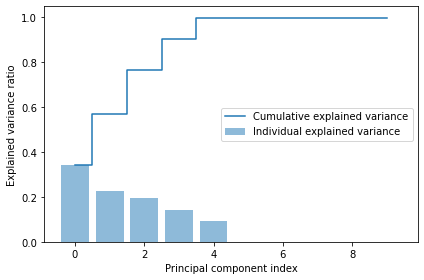

In [65]:
### MIGHT PCA BE USEFUL??

from sklearn.decomposition import PCA

pca_pipeline = Pipeline(steps=[
    ('prep', preprocessor_ohe), 
    ('pca', PCA(n_components = 10)) 
])

pca_pipeline.fit(X_train)
pca_pipeline['pca'].explained_variance_ratio_
exp_var_pca = pca_pipeline['pca'].explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [69]:
### ATTEMPT TO USE PCA TO DENOISE AND COMPRESS DATA

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1)
log.append('train_test_split: train_size=0.85')

##? First pass with all models, with slight tuning
gnb = GaussianNB()
lrc = LogisticRegression()
svc = SVC()
abc = AdaBoostClassifier()
rfc = RandomForestClassifier()
hgb = HistGradientBoostingClassifier()


###? commented out params are the result of previous runs, honing in on best params
gnb_grid = {
    'var_smoothing' : [1e-4], #1e-9, 1e-8, 1e-7, 
}
lrc_grid = {
    'max_iter'  : [1000], 
    'penalty'   : ['l1','l2'], 
    'solver'    : ['saga'],
    'C'         : [0.1,1,10], #[0, 0.001, 0.01, 0.1, 1], 
}
svc_grid = {
    'kernel'    : ['rbf'], # linear, poly, etc didn't converge
    'C'         : [2,4,6],# [4,8,16], #[0.01, 0.1, 1, 10], 
    'gamma'     : [0.01], #[0.01, 0.1, 1, 10], 
}
abc_grid = {
    'learning_rate' : [0.1], 
    'n_estimators'  : [1000], #[100,200,300],
}
rfc_grid = {
    'max_depth' : [15], # [5,10,15,20], 
    'ccp_alpha' : [0], 
    'bootstrap' : [True],
    'n_estimators' : [100],
    'max_features' : [2],
    'min_samples_leaf' : [2],#[1],
}
hgb_grid = {
    'learning_rate'     : [0.1], 
    'max_leaf_nodes'    : [8], # [8, 16], 
    'l2_regularization' : [0], #[0, 0.01, 0.1], 
    'max_iter'          : [1000],
    'validation_fraction': [0.1],
    'min_samples_leaf'  : [2],
}

gnb_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('pca', PCA(n_components = 4)), ('clf', GridSearchCV(gnb, param_grid=gnb_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
lrc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('pca', PCA(n_components = 4)), ('clf', GridSearchCV(lrc, param_grid=lrc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
svc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('pca', PCA(n_components = 4)), ('clf', GridSearchCV(svc, param_grid=svc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
abc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('pca', PCA(n_components = 4)), ('clf', GridSearchCV(abc, param_grid=abc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
rfc_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('pca', PCA(n_components = 4)), ('clf', GridSearchCV(rfc, param_grid=rfc_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])
hgb_gs = Pipeline(steps=[('prep', preprocessor_ohe), ('pca', PCA(n_components = 4)), ('clf', GridSearchCV(hgb, param_grid=hgb_grid, cv=10, scoring='accuracy', n_jobs=-1)) ])

gnb_gs.fit(X_train, y_train)
lrc_gs.fit(X_train, y_train)
svc_gs.fit(X_train, y_train)
abc_gs.fit(X_train, y_train)
rfc_gs.fit(X_train, y_train)
hgb_gs.fit(X_train, y_train)

clfs = [ 'gnb_gs', 'lrc_gs', 'svc_gs', 'abc_gs', 'rfc_gs', 'hgb_gs' ]

results = modelevaluation(clfs)
display(results)
display(results['params'].values)

c:\Anaconda\envs\python\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Anaconda\envs\python\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,name,train_acc,test_acc,train_auc,test_auc,params
0,gnb_gs,0.566653,0.571319,0.564994,0.563096,{'var_smoothing': 0.0001}
1,lrc_gs,0.71011,0.723926,0.709175,0.719297,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ..."
2,svc_gs,0.800514,0.786043,0.800272,0.784923,"{'C': 6, 'gamma': 0.01, 'kernel': 'rbf'}"
3,abc_gs,0.782921,0.790644,0.782768,0.790021,"{'learning_rate': 0.1, 'n_estimators': 1000}"
4,rfc_gs,0.918257,0.806748,0.918266,0.80647,"{'bootstrap': True, 'ccp_alpha': 0, 'max_depth..."
5,hgb_gs,0.898768,0.793712,0.898711,0.793655,"{'l2_regularization': 0, 'learning_rate': 0.1,..."


array([{'var_smoothing': 0.0001},
       {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'},
       {'C': 6, 'gamma': 0.01, 'kernel': 'rbf'},
       {'learning_rate': 0.1, 'n_estimators': 1000},
       {'bootstrap': True, 'ccp_alpha': 0, 'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 100},
       {'l2_regularization': 0, 'learning_rate': 0.1, 'max_iter': 1000, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'validation_fraction': 0.1}],
      dtype=object)

- ### After some tuning, best performance is coming from HGBM, without using any PCA decomposition, which is to be expected, so we will tune this further.

In [70]:
hgbm1 = Pipeline(steps=[('prep', preprocessor_oe ), ('clf', HistGradientBoostingClassifier(categorical_features=cat_feature_mask, learning_rate=0.05, max_leaf_nodes=8, l2_regularization=0.1, max_iter=300, validation_fraction=0.1, min_samples_leaf=2, random_state=0) ) ])
hgbm2 = Pipeline(steps=[('prep', preprocessor_oe ), ('clf', HistGradientBoostingClassifier(categorical_features=cat_feature_mask, learning_rate=0.05, max_leaf_nodes=8, l2_regularization=0.1, max_iter=300, validation_fraction=0.1, min_samples_leaf=3, random_state=0) ) ])
hgbm3 = Pipeline(steps=[('prep', preprocessor_oe ), ('clf', HistGradientBoostingClassifier(categorical_features=cat_feature_mask, learning_rate=0.05, max_leaf_nodes=8, l2_regularization=0.1, max_iter=300, validation_fraction=0.1, min_samples_leaf=4, random_state=0) ) ])
hgbm4 = Pipeline(steps=[('prep', preprocessor_oe ), ('clf', HistGradientBoostingClassifier(categorical_features=cat_feature_mask, learning_rate=0.05, max_leaf_nodes=8, l2_regularization=0.1, max_iter=300, validation_fraction=0.1, min_samples_leaf=5, random_state=0) ) ])

clfs = [hgbm1,hgbm2,hgbm3,hgbm4]

for clf in clfs:
    clf.fit(X_train, y_train)

results = modelevaluation(['hgbm1','hgbm2','hgbm3','hgbm4'])
display(results)

,name,train_acc,test_acc,train_auc,test_auc,params
0,hgbm1,0.850724,0.822086,0.85069,0.821886,
1,hgbm2,0.851942,0.817485,0.851908,0.817388,
2,hgbm3,0.850724,0.821319,0.850673,0.821171,
3,hgbm4,0.852213,0.824387,0.852181,0.824276,


# <p style='color:#f70'> **4. BEST MODEL RETRAINED USING ALL DATA FOR FINAL USE**

In [ ]:
hgbm_fitall = Pipeline(steps=[('prep', preprocessor_oe ), ('clf', HistGradientBoostingClassifier(categorical_features=cat_feature_mask, learning_rate=0.05, max_leaf_nodes=8, l2_regularization=0.1, max_iter=300, validation_fraction=0.1, min_samples_leaf=2, random_state=0) ) ])

log.append(hgbm_fitall.get_params())
_ = hgbm_fitall.fit(X, y)

In [ ]:
### saving logs is useful to track processes across runs

display(log)

['impute: some 0s based on EDA (Cryosleep spent 0, children 12 and under spent 0.)',
 'impute: other numeric cols using KNNImputer.fit(train)',
 'new_features: int groupsize, str cabin_deck, int cabin_number, str cabin_side, float sumspend',
 'new_features: log_transform: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, sumspend',
 'new_features: age_group bins=arange(-1,90,3), cabin_number_group bins=np.arange(0,2000,100)',
 'outliers: not handled',
 'cat_features: HomePlanet, CryoSleep, Destination, VIP, cabin_deck, cabin_side, cabin_number_group, age_group',
 'num_features: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, sumspend, RoomService_log, FoodCourt_log, ShoppingMall_log, Spa_log, VRDeck_log, sumspend_log, groupsize',
 'onehot and ordinal encoders for cats, robustscaler for nums',
 {'memory': None,
  'steps': [('prep',
    ColumnTransformer(transformers=[('categorical',
                                     Pipeline(steps=[('encoder',
                               

## <p style='color:#f70'> Export Kaggle Predictions

In [ ]:
def exportpreds(clf, X_test, filename):
    y_pred = clf.predict(X_test)
    results = pd.Series(y_pred, index=X_test.index, name="Transported").astype('object').replace({1.0:'True', 0.0:'False'})
    results.to_csv(filename)

# exportpreds(hgbm_fitall, X_exttest, 'res_hgbfitall2.csv')